## Salamandra 2B Finetuning

In [ ]:
pip install -U numpy pandas codecarbon enum34 mkl jupyterlab tqdm openpyxl torch transformers accelerate deepspeed datasets sentencepiece transformers[sentencepiece] peft bitsandbytes

In [ ]:
pue = 1.12
country_iso_code = 'ESP'
region='ESP'
cloud_provider='gcp'
cloud_region='europe-southwest1'
country_2letter_iso_code = 'ES'

# Para este caso, únicamnete se definirá el nombre del fichero de salida. Si el usuario lo desea, puede añadir otros.
output_file = 'test_emissions_2b_finetuning_text2sql.csv'

In [ ]:
from codecarbon import OfflineEmissionsTracker
tracker = OfflineEmissionsTracker(
        country_iso_code=country_iso_code,
        region=region,
        cloud_provider=cloud_provider,
        cloud_region=cloud_region,
        country_2letter_iso_code=country_2letter_iso_code,
        pue=pue,
        output_file = output_file
)

[codecarbon INFO @ 19:10:30] offline tracker init
[codecarbon WARNING @ 19:10:30] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 19:10:30] [setup] RAM Tracking...
[codecarbon INFO @ 19:10:30] [setup] CPU Tracking...
[codecarbon WARNING @ 19:10:32] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 19:10:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz
[codecarbon WARNING @ 19:10:32] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 19:10:32] [setup] GPU Tracking...
[codecarbon INFO @ 19:10:32] No GPU found.
[codecarbon INFO @ 19:10:32] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tra

In [10]:
# Inicio del proceso de medición
tracker.start()

### Empieza la parte de entrenamiento

In [ ]:
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, TrainerCallback, DataCollatorForSeq2Seq,
    StoppingCriteria, StoppingCriteriaList, set_seed
)
from tqdm import tqdm
import torch
import os
import random
import numpy as np

SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Dado que se trata de un modelo de instrucciones, necesitamos un stop token
MODEL_NAME = "BSC-LT/salamandra-2b-instruct"
STOP_TOKEN = ";" # Util porque las consultas SQL terminan con ;

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto"
)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=-100,
)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/anaconda/envs/azureml_py310_sdkv2/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
class StopOnTokens(StoppingCriteria):
    """
    Halt generation as soon as the model emits any of the given token IDs.
    """
    def __init__(self, stop_token_ids: list[int]):
        super().__init__()
        self.stop_token_ids = set(stop_token_ids)

    def __call__(self, input_ids, scores, **kwargs):
        # stops if *any* sequence in the batch just produced a stop token
        last_tokens = input_ids[:, -1].tolist()
        return any(tok in self.stop_token_ids for tok in last_tokens)

#### Dataset analysis

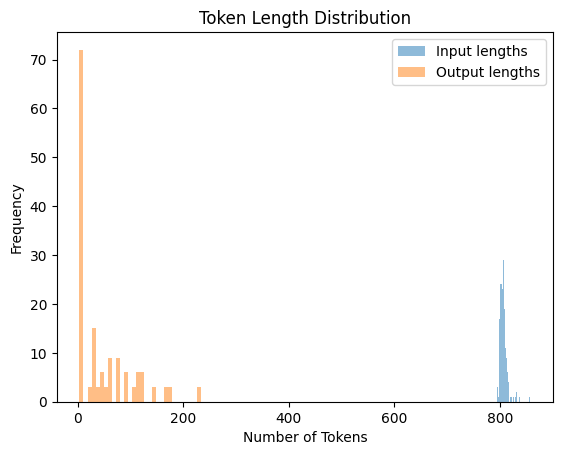

Max input length: 858
Max output length: 233


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('Text2SQL_Data.xlsx')
with open('Estructura_Base_de_Datos_Gemini.txt', 'r') as f:
    estructura_sql = ''.join(f.readlines())
input_template = """
### Base de datos:
{estructura_sql}
### Instrucción: {prompt}
### SQL:
""".strip()
df['Prompt'] = df['Prompt'].apply(
    lambda x: input_template.format(estructura_sql=estructura_sql, prompt=x)
)
input_lengths = [len(tokenizer(text)['input_ids']) for text in df['Prompt']]
output_lengths = [len(tokenizer(text)['input_ids']) for text in df['SQL']]

plt.hist(input_lengths, bins=30, alpha=0.5, label='Input lengths')
plt.hist(output_lengths, bins=30, alpha=0.5, label='Output lengths')
plt.legend()
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

print(f"Max input length: {max(input_lengths)}")
print(f"Max output length: {max(output_lengths)}")

#### Dataset tokenizing

In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd

ds = DatasetDict()

df = pd.read_excel('Text2SQL_Data.xlsx')
with open('Estructura_Base_de_Datos_Gemini.txt', 'r') as f:
    estructura_sql = ''.join(f.readlines())
input_template = """
### Base de datos:
{estructura_sql}
### Instrucción: {prompt}
### SQL:
""".strip()
df['Prompt'] = df['Prompt'].apply(
    lambda x: input_template.format(estructura_sql=estructura_sql, prompt=x)
)
ds['train'] = Dataset.from_pandas(df[df['Split'] == 'Train'].sample(frac=1, random_state=42).reset_index(drop=True))
ds['test'] = Dataset.from_pandas(df[df['Split'] == 'Test'].sample(frac=1, random_state=42).reset_index(drop=True))

def tokenize_function(examples):
    tokenized_data = {
        "input_ids": [],
        "attention_mask": [],
        "labels": []
    }
    for i in range(len(examples["Prompt"])):
        prompt_text = examples["Prompt"][i]
        sql_text = examples["SQL"][i].rstrip().rstrip(";") + ";"  # ensure one trailing semicolon
        prompt_tokens_ids = tokenizer.encode(prompt_text, add_special_tokens=False)
        sql_tokens_ids = tokenizer.encode(sql_text, add_special_tokens=False)
        full_input_ids = [tokenizer.bos_token_id] + prompt_tokens_ids + sql_tokens_ids + [tokenizer.eos_token_id]

        max_length = 1280 # Your chosen max_length
        full_input_ids = full_input_ids[:max_length]
        labels = [-100] * (1 + len(prompt_tokens_ids)) + full_input_ids[1 + len(prompt_tokens_ids):]
        labels = labels[:max_length]
        attention_mask = [1] * len(full_input_ids)

        tokenized_data["input_ids"].append(full_input_ids)
        tokenized_data["attention_mask"].append(attention_mask)
        tokenized_data["labels"].append(labels)

    return tokenized_data

encoded_dataset = ds.map(tokenize_function, batched=True)
encoded_dataset

Map: 100%|██████████| 21/21 [00:00<00:00, 1521.25 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Indice', 'Prompt', 'SQL', 'Split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['Indice', 'Prompt', 'SQL', 'Split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 21
    })
})

#### Training

In [ ]:
training_args = TrainingArguments(
    output_dir="./2b_results_text2sql",
    logging_dir="./2b_logs_text2sql",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=15,  # Keeps all checkpoints
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=15,
    learning_rate=5e-5,
    weight_decay=0.001,
    warmup_steps=50,  # Add warmup steps to help learning rate stabilization
    fp16=True,
    report_to=[]
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/anaconda/envs/azureml_py310

In [ ]:
def generate_predictions(model, tokenizer, dataset, output_dir, epoch, batch_size=4):
    model.eval()
    device = model.device # Get device from the model (e.g., 'cuda:0' or 'cpu')

    all_generated_sqls = []
    all_prompts_text = []
    all_reference_sqls = []

    # Extract all prompts and references first to avoid repeated indexing into dataset
    prompts_to_process = [example["Prompt"] for example in dataset]
    references_to_process = [example["SQL"] for example in dataset]

    stop_token_id = tokenizer.convert_tokens_to_ids(STOP_TOKEN)
    stopping_criteria = StoppingCriteriaList([StopOnTokens([stop_token_id])])

    for i in tqdm(range(0, len(prompts_to_process), batch_size), desc=f"Generating Predictions Epoch {epoch}"):
        batch_prompt_texts = prompts_to_process[i:i + batch_size]
        batch_reference_sqls = references_to_process[i:i + batch_size]

        inputs = tokenizer(
            batch_prompt_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024
        ).to(device)

        with torch.no_grad():
            output_sequences = model.generate(
                input_ids=inputs.input_ids,
                attention_mask=inputs.attention_mask,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                max_new_tokens=256,
                stopping_criteria=stopping_criteria,
            )

        prompt_len_in_batch = inputs.input_ids.shape[1]
        batch_generated_ids = output_sequences[:, prompt_len_in_batch:]

        batch_generated_sqls = tokenizer.batch_decode(batch_generated_ids, skip_special_tokens=True)

        all_generated_sqls.extend(batch_generated_sqls)
        all_prompts_text.extend(batch_prompt_texts)
        all_reference_sqls.extend(batch_reference_sqls)

    # Create DataFrame
    df = pd.DataFrame({
        "Prompt": all_prompts_text,
        "Reference SQL": all_reference_sqls,
        "Generated SQL": all_generated_sqls
    })

    # Save to CSV
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(os.path.join(output_dir, f"test_generations_epoch{epoch}.csv"), index=False)

In [ ]:
class PredictionCallback(TrainerCallback):
    def __init__(self, tokenizer, output_dir):
        self.output_dir = output_dir
        self.tokenizer = tokenizer

    def on_epoch_end(self, args, state, control, model=None, **kwargs):
        epoch = int(state.epoch)

        generate_predictions(
            model=model,
            tokenizer=self.tokenizer,
            dataset=ds['test'],
            output_dir=self.output_dir,
            epoch=epoch
        )

        super().on_epoch_end(args, state, control, **kwargs)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=None,
    data_collator=data_collator,
    callbacks=[
        PredictionCallback(tokenizer, output_dir="./2b_results_text2sql")
    ]
)
trainer.train()

/tmp/ipykernel_5036/1404848824.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `EvalTrainer.__init__`. Use `processing_class` instead.
  trainer = EvalTrainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To dis

Step,Training Loss
10,14.619900
20,9.293300
30,3.347000
40,1.972700
50,1.978500
60,1.820000


[codecarbon INFO @ 20:18:21] Energy consumed for RAM : 0.078397 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:18:21] Delta energy consumed for CPU with constant : 0.000910 kWh, power : 195.0 W
[codecarbon INFO @ 20:18:21] Energy consumed for All CPU : 0.246593 kWh
[codecarbon INFO @ 20:18:21] 0.324990 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:18:36] Energy consumed for RAM : 0.078686 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:18:36] Delta energy consumed for CPU with constant : 0.000910 kWh, power : 195.0 W
[codecarbon INFO @ 20:18:36] Energy consumed for All CPU : 0.247503 kWh
[codecarbon INFO @ 20:18:36] 0.326190 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:18:36] 0.010473 g.CO2eq/s mean an estimation of 330.26303224942257 kg.CO2eq/year
[codecarbon INFO @ 20:18:51] Energy consumed for RAM : 0.078975 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:18:51] Delta energy consumed for CPU with constant : 0.000910 kWh, power : 195.0 W
[codecar

BlockingIOError: [Errno 11] Resource temporarily unavailable: './2b_results/checkpoint-68/model.safetensors.index.json'

In [24]:
trainer.train(resume_from_checkpoint='./2b_results/checkpoint-51')

[codecarbon INFO @ 20:46:09] Energy consumed for RAM : 0.110550 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:46:09] Delta energy consumed for CPU with constant : 0.000917 kWh, power : 195.0 W
[codecarbon INFO @ 20:46:09] Energy consumed for All CPU : 0.347738 kWh
[codecarbon INFO @ 20:46:09] 0.458288 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:46:24] Energy consumed for RAM : 0.110836 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:46:24] Delta energy consumed for CPU with constant : 0.000901 kWh, power : 195.0 W
[codecarbon INFO @ 20:46:24] Energy consumed for All CPU : 0.348639 kWh
[codecarbon INFO @ 20:46:24] 0.459475 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:46:39] Energy consumed for RAM : 0.111126 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:46:39] Delta energy consumed for CPU with constant : 0.000910 kWh, power : 195.0 W
[codecarbon INFO @ 20:46:39] Energy consumed for All CPU : 0.349549 kWh
[codecarbon INFO @ 20:46:39] 0.460675 k

Step,Training Loss
60,1.687400
70,1.192000
80,1.151500
90,0.924300
100,1.028800
110,0.830600
120,1.049300
130,0.784300
140,0.703600
150,0.828500


[codecarbon INFO @ 20:51:54] Energy consumed for RAM : 0.117202 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:51:54] Delta energy consumed for CPU with constant : 0.000910 kWh, power : 195.0 W
[codecarbon INFO @ 20:51:54] Energy consumed for All CPU : 0.368665 kWh
[codecarbon INFO @ 20:51:54] 0.485868 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:52:09] Energy consumed for RAM : 0.117491 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:52:09] Delta energy consumed for CPU with constant : 0.000910 kWh, power : 195.0 W
[codecarbon INFO @ 20:52:09] Energy consumed for All CPU : 0.369575 kWh
[codecarbon INFO @ 20:52:09] 0.487067 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:52:24] Energy consumed for RAM : 0.117781 kWh. RAM Power : 62.0 W
[codecarbon INFO @ 20:52:24] Delta energy consumed for CPU with constant : 0.000910 kWh, power : 195.0 W
[codecarbon INFO @ 20:52:24] Energy consumed for All CPU : 0.370485 kWh
[codecarbon INFO @ 20:52:24] 0.488266 k

TrainOutput(global_step=160, training_loss=0.6821079939603806, metrics={'train_runtime': 2948.7191, 'train_samples_per_second': 0.448, 'train_steps_per_second': 0.054, 'total_flos': 3325380287004672.0, 'train_loss': 0.6821079939603806, 'epoch': 9.666666666666666})

In [36]:
# Fin del proceso de medición
emissions = tracker.stop()

# Accede a las emisiones calculadas
print(f"Emissions: {emissions} kg CO₂eq")